In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

In [17]:
# Load the data
X_train = pd.read_csv('X_train.csv')
test_df = pd.read_csv('X_test.csv')

# Step 1: Filter out post-collision data
collision_filter = (X_train['x_1'] == 0) & (X_train['y_1'] == 0) & (X_train['x_2'] == 0) & (X_train['y_2'] == 0) & (X_train['x_3'] == 0) & (X_train['y_3'] == 0)
X_train_filtered = X_train[~collision_filter]

# Step 2: Identify unique initial positions
initial_conditions = X_train_filtered[X_train_filtered['t'] == 0].copy()


###Novo###
# Compute distances between bodies
initial_conditions['d_12'] = np.sqrt(
    (initial_conditions['x_1'] - initial_conditions['x_2']) ** 2 +
    (initial_conditions['y_1'] - initial_conditions['y_2']) ** 2
)
initial_conditions['d_13'] = np.sqrt(
    (initial_conditions['x_1'] - initial_conditions['x_3']) ** 2 +
    (initial_conditions['y_1'] - initial_conditions['y_3']) ** 2
)
initial_conditions['d_23'] = np.sqrt(
    (initial_conditions['x_2'] - initial_conditions['x_3']) ** 2 +
    (initial_conditions['y_2'] - initial_conditions['y_3']) ** 2
)
###Novo###



###test###
# Filter initial conditions at t=0
initial_conditions_test = test_df[test_df['t'] == 0].copy()

# Compute distances between bodies
initial_conditions_test['d_12'] = np.sqrt(
    (initial_conditions_test['x0_1'] - initial_conditions_test['x0_2']) ** 2 +
    (initial_conditions_test['y0_1'] - initial_conditions_test['y0_2']) ** 2
)
initial_conditions_test['d_13'] = np.sqrt(
    (initial_conditions_test['x0_1'] - initial_conditions_test['x0_3']) ** 2 +
    (initial_conditions_test['y0_1'] - initial_conditions_test['y0_3']) ** 2
)
initial_conditions_test['d_23'] = np.sqrt(
    (initial_conditions_test['x0_2'] - initial_conditions_test['x0_3']) ** 2 +
    (initial_conditions_test['y0_2'] - initial_conditions_test['y0_3']) ** 2
)

#test_features_df = initial_conditions_test[['x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3']]
# Prepare test features including distances
test_features_df = initial_conditions_test[
    ['d_12', 'd_13', 'd_23']
]

###end test###

# Create a unique identifier based on rounded initial positions
initial_conditions['trajectory_id'] = (
    initial_conditions['x_1'].round(6).astype(str) + '_' +
    initial_conditions['y_1'].round(6).astype(str) + '_' +
    initial_conditions['x_2'].round(6).astype(str) + '_' +
    initial_conditions['y_2'].round(6).astype(str) + '_' +
    initial_conditions['x_3'].round(6).astype(str) + '_' +
    initial_conditions['y_3'].round(6).astype(str)
).astype('category').cat.codes



# Map this identifier back to the main dataframe based on match at t=0
X_train_filtered = X_train_filtered.merge(initial_conditions[['trajectory_id', 't', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']],
                                          on=['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3'],
                                          how='left')

# Fill missing trajectory_ids for the rest of the times using forward fill
X_train_filtered['trajectory_id'] = X_train_filtered['trajectory_id'].ffill()

# Organize data by trajectory ID without using lambda
trajectories = {}
for trajectory_id in X_train_filtered['trajectory_id'].unique():
    trajectory_data = X_train_filtered[X_train_filtered['trajectory_id'] == trajectory_id]
    trajectory_data_sorted = trajectory_data.sort_values(by='t')
    trajectories[trajectory_id] = trajectory_data_sorted[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']].values.flatten()

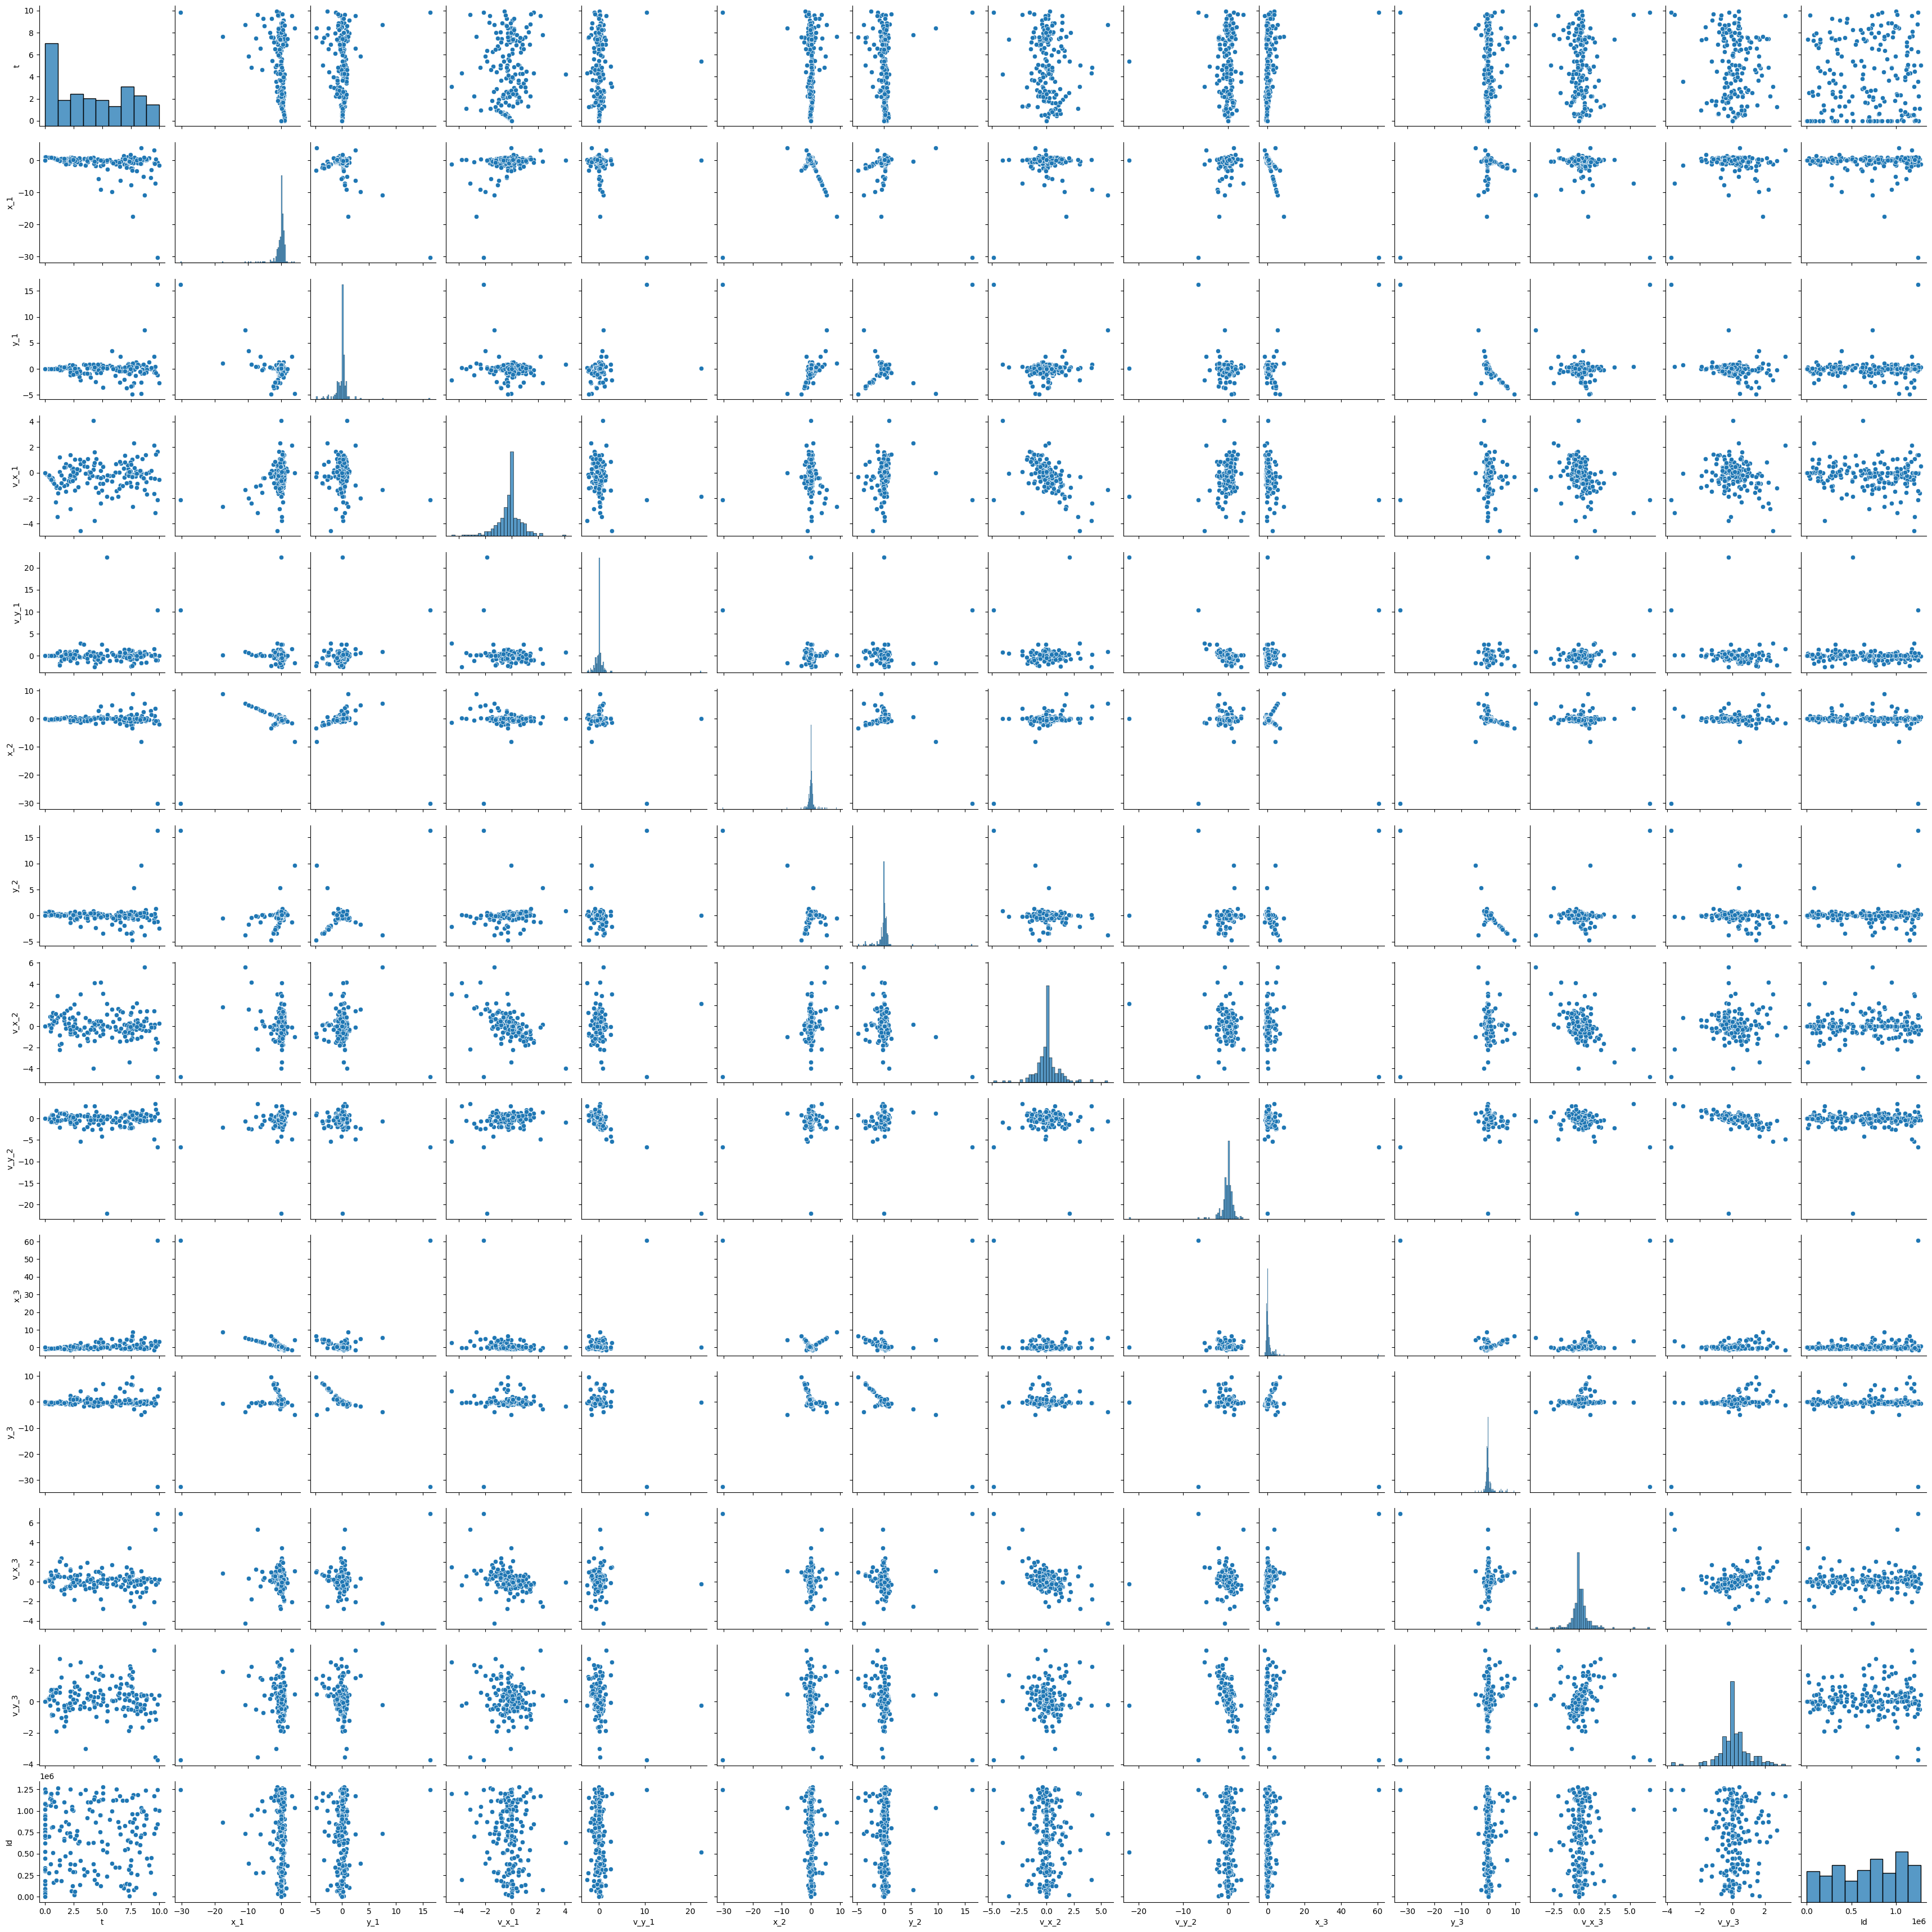

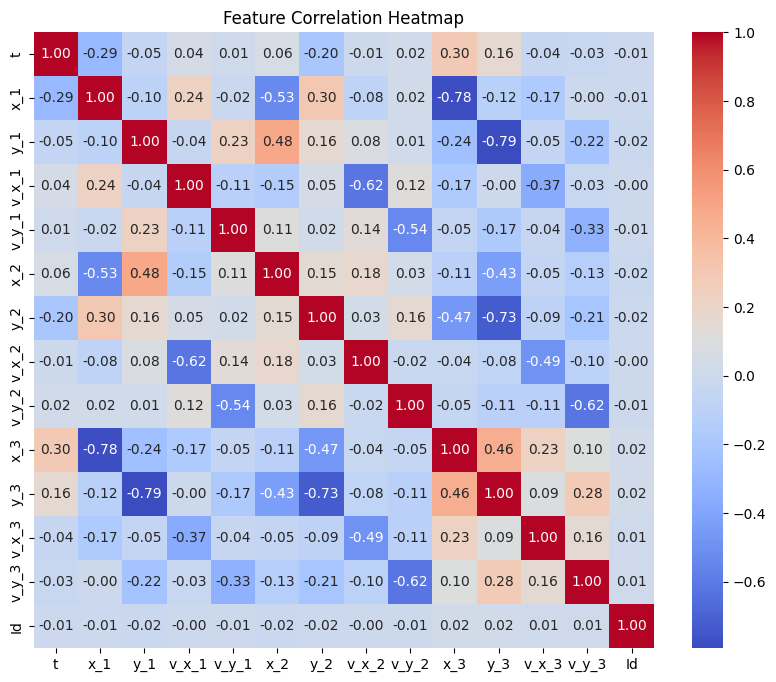

In [3]:
# Sampling a subset of data for visualization to make it manageable
sampled_data = X_train.sample(n=200, random_state=42)  # Adjust sample size as needed

# Creating pairplot
sns.pairplot(sampled_data, kind="scatter")  # 'scatter' can be changed to 'hist' for histogram diagonal
plt.show()

# Calculate the correlation matrix
corr = X_train.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your number of features
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")  # fmt parameter formats the annotation labels
plt.title("Feature Correlation Heatmap")
plt.show()

In [38]:
from keras.preprocessing.sequence import pad_sequences # type: ignore
import pickle
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor


features = []
targets = []

# Iterate over each trajectory's data
for trajectory_id in X_train_filtered['trajectory_id'].unique():
    trajectory_data = X_train_filtered[X_train_filtered['trajectory_id'] == trajectory_id]
    trajectory_data_sorted = trajectory_data.sort_values(by='t')
    
    # Extract initial positions
    initial_row = trajectory_data_sorted.iloc[0]
    x1, y1 = initial_row['x_1'], initial_row['y_1']
    x2, y2 = initial_row['x_2'], initial_row['y_2']
    x3, y3 = initial_row['x_3'], initial_row['y_3']
    
    # Compute distances
    d_12 = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    d_13 = np.sqrt((x1 - x3) ** 2 + (y1 - y3) ** 2)
    d_23 = np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)
    
    # Prepare initial features
    initial_features = [d_12, d_13, d_23]
    
    # All subsequent positions as targets
    subsequent_positions = trajectory_data_sorted[['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']].values[1:].flatten()
    
    features.append(initial_features)
    targets.append(subsequent_positions)

features = np.array(features)
# Assuming your data is stored as lists of arrays in 'features' and 'targets'
# Let's find the maximum length of sequences in targets for padding
max_len = max(len(t) for t in targets)

# Now pad all target sequences to have the same length
targets_padded = pad_sequences(targets, maxlen=max_len, dtype='float64', padding='post')



# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets_padded, test_size=0.2, random_state=42)



pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())  
    #('model', LinearRegression())
])

#Hyperparameter tuning
# Define the parameter grid
param_grid = {
    'poly__degree': [2, 3, 4, 5, 6, 7, 8, 9],
    'model__n_neighbors': [3, 5, 7, 9, 11]
}

# Perform Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=1000, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")

# Predict on the test set using best_model
y_pred = best_model.predict(X_test)

# Calculate MSE
mse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {mse}')


# Save the best_model to disk
model_filename = 'three_body_problem_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

Best Parameters: {'model__n_neighbors': 5, 'poly__degree': 3}
Root Mean Squared Error: 0.7698219288577904


In [39]:
# Load the model from disk
with open('three_body_problem_model.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

# Use the loaded pipeline to predict
test_features = test_features_df.values
predictions = loaded_pipeline.predict(test_features)

# Extract the initial positions from initial_conditions_test
initial_positions = initial_conditions_test[['x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3']].values

# Reshape and prepare for concatenation
initial_positions_reshaped = initial_positions.reshape(-1, 1, 6)

# Determine the number of timesteps in your predictions
num_timesteps = predictions.shape[1] // 6

# Reshape predictions to have shape (N_samples, num_timesteps, 6)
predictions_reshaped = predictions.reshape(-1, num_timesteps, 6)

# Concatenate the initial positions with the predictions
predictions_with_initial = np.concatenate([initial_positions_reshaped, predictions_reshaped], axis=1)

# Prepare data for submission
submission_data = []
for idx in range(len(predictions_with_initial)):
    num_timesteps = predictions_with_initial.shape[1]
    for t in range(num_timesteps):
        unique_id = idx * num_timesteps + t
        positions = predictions_with_initial[idx, t]
        submission_data.append([unique_id] + positions.tolist())

# Convert submission data into DataFrame
submission_df = pd.DataFrame(submission_data, columns=["Id", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"])

# Save the DataFrame to CSV for submission
submission_df.to_csv('knn_submission.csv', index=False)


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_sequence_predictions(y_test_seq, y_pred_seq, sample_idx=0):
    """
    Plots the true and predicted sequences for a given sample.
    """
    labels = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
    time_steps = np.arange(y_test_seq.shape[1])
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(3, 2, i + 1)
        plt.plot(time_steps, y_test_seq[sample_idx, :, i], label='True')
        plt.plot(time_steps, y_pred_seq[sample_idx, :, i], label='Predicted')
        plt.title(labels[i])
        plt.xlabel('Time Step')
        plt.ylabel(labels[i])
        plt.legend()
    plt.tight_layout()
    plt.show()

